In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PSD.LISAcalPSD import LISAcalPSD1, LISAcalPSD2 
from pycbc.types.frequencyseries import FrequencySeries

# 参数设置

In [2]:
sampFreq = 2                #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration = 655356           #信号持续时间(duration of signal)


n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal)
                            #为2的幂时，快速傅里叶变化效率最高
                            #n =  duration * sampFreqint = (duration / sampIntrvl)

sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                              # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                              #            = sampFreq / n  
        

f = sampFreq/2             #信号模式的最大频率

print("采样频率为%dHz，信号持续时间%ds, 时域信号采样%d 个点"%(sampFreq,duration,n))
print("信号中可分析最大频率为%fHz"%f)
print("\n采样周期，即时域分辨率为%fs"%(sampIntrvl))
print("信号频域的频率间隔，即频域分辨率为%fHz"%freqIntrvl);

采样频率为2Hz，信号持续时间655356s, 时域信号采样1310712 个点
信号中可分析最大频率为1.000000Hz

采样周期，即时域分辨率为0.500000s
信号频域的频率间隔，即频域分辨率为0.000002Hz


# 构建用于pyCBC的PSD频率序列

In [3]:
#注意： 会有除0警告，可以忽略
freqVec = np.linspace(0, 1, int(1/freqIntrvl))
#构建频率序列(必须等频率间隔)，这里我们开始于0Hz(必须开始于0，否则导入pyCBC的结果不对), 结束于1Hz，频率间隔为上面的freqIntrvl

#LISA PSD 模拟函数
psd1 = LISAcalPSD1(freqVec) 

'''
1. Babak, S., Fang, H., Gair, J. R., Glampedakis, K. & Hughes, S. A. Kludge’
gravitational waveforms for a test-body orbiting a Kerr black hole. Phys.Rev. D 75, 024005 (2007).

'''

psd2 = LISAcalPSD2(freqVec)


'''
1. Sathyaprakash, B. S. & Schutz, B. F. 
Physics, Astrophysics and Cosmology with Gravitational Waves. Living Rev Relativ 12, 122004 (2009).

'''

#构建用于pyCBC的FrequencySeries
psd1 = FrequencySeries(psd1, delta_f=freqIntrvl, epoch='', dtype=None, copy=True)
psd2 = FrequencySeries(psd2, delta_f=freqIntrvl, epoch='', dtype=None, copy=True)

/Users/ysc/codes/all/matchGW/PSD/LISAcalPSD.py:40: RuntimeWarning: divide by zero encountered in true_divide
  r = (1/ u**2) * ( (1 + np.cos(u)**2) * (1/3 - 2/u**2) + np.sin(u)**2 + 4*np.sin(u)*np.cos(u)/(u**3) )
/Users/ysc/codes/all/matchGW/PSD/LISAcalPSD.py:40: RuntimeWarning: invalid value encountered in true_divide
  r = (1/ u**2) * ( (1 + np.cos(u)**2) * (1/3 - 2/u**2) + np.sin(u)**2 + 4*np.sin(u)*np.cos(u)/(u**3) )
/Users/ysc/codes/all/matchGW/PSD/LISAcalPSD.py:42: RuntimeWarning: divide by zero encountered in true_divide
  psd1 = (8.08e-48 / ((2*np.pi*freqVec)**4) + 5.52e-41)
/Users/ysc/codes/all/matchGW/PSD/LISAcalPSD.py:43: RuntimeWarning: divide by zero encountered in true_divide
  psd2 = (2.88e-48 / ((2*np.pi*freqVec)**4) + 5.52e-41) / r
/Users/ysc/codes/all/matchGW/PSD/LISAcalPSD.py:77: RuntimeWarning: divide by zero encountered in power
  psd = ((xVec/10)**(-4) + 173 + xVec**2) * S0


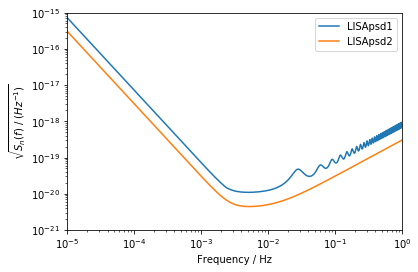

In [4]:
#绘制 频率 - sqrt(PSD) 图
 
plt.figure()
plt.loglog(psd1.sample_frequencies, np.sqrt(psd1), label = 'LISApsd1')
plt.loglog(psd1.sample_frequencies, np.sqrt(psd2), label = 'LISApsd2')

plt.xlim(1e-5,1e0)
plt.ylim(1e-21,1e-15)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.show()